In [1]:
#@title Define LinearTrack and GridWorld
# =====================================
#           IMPORT MODULES            #
# =====================================
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# =====================================
#              GW CLASS               #
# =====================================
class GridWorld(object):
    def __init__(self, rows=20, cols=20, rewards={(5,5):10},
                 env_type=None, rho=0.0, step_penalization=-0.01,
                 terminals=None, obstacles=None, jumps=None,
                 port_shift=None, barheight=None,
                 around_reward=False,
                 **kwargs):
        '''
        :param rows (int): specifying width (x dim) of grid
        :param cols (int): specifying height (y dim) of grid
        :param rewards (dict): reward location coordinates as keys and reward magnitude as values

        :param env_type (str): [None, 'bar','room','tmaze', 'triple_reward']
        :param rho (float): density of obstacles to be randomly positioned in environment
        :param step_penalization (float): penalization for each step (small negative reward)

        :param terminals (list): terminal state coordinates
        :param obstacles (list): obstacle coordinates
        :param jumps (dict): keys and values are coordinates in the environment (x,y):(w,z)
                             where agent can select jump action in coordinate (x,y) and moves to coordinate (w,z)

        :param port_shift (str):  ['equal', 'left', 'right']: type of probability distribution for Kirth's task
        :param barheight (int): height of horizontal line of obstacles dividing the plane

        :param around_reward (bool): whether to randomly choose agent starting location around reward location
        '''
        self.shape = (rows, cols)
        self.c = cols
        self.r = rows

        self.maze_type = env_type
        self.rho = rho

        # basic set up states, rewards
        self.nstates = self.c*self.r
        self.rewards = rewards

        # populate list of obstacles
        self.obstacles_list = obstacles

        if self.maze_type == 'bar':
            if barheight is not None:
                self.barheight 	= barheight
        self.grid, self.useable, self.obstacles_list = self.buildGrid()

        # populate list of terminals
        if terminals is not None:
            if isinstance(terminals, tuple):
                self.terminal2D = [terminals]
                self.terminal = [self.twoD2oneD(terminals)]
            else:
                self.terminal2D = terminals
                self.terminal = [self.twoD2oneD((r,c)) for r,c in terminals]
        else:
            self.terminal2D = []
            self.terminal = []

        # populate list of jump states
        if jumps is not None:
            self.jump = jumps
            self.jump_from = [self.twoD2oneD((r,c)) for r,c in list(jumps.keys())]
            self.jump_to = [self.twoD2oneD((r,c)) for r,c in list(jumps.values())]
        else:
            self.jump = None
            self.jump_from = []
            self.jump_to = []

        # Actions
        self.action_list    = kwargs.get('actionlist', ['Down', 'Up', 'Right', 'Left', 'Jump', 'Poke'])
        self.action_dict    = kwargs.get('actiondict', {x: ind for ind, x in enumerate([x[0] for x in self.action_list])})
        self.nactions       = len(self.action_list)
        self.buildTransitionMatrix()

        # Reward
        self.finish_after_first_reward = kwargs.get('finish_after_first_reward',True)
        if self.finish_after_first_reward:
            # add reward location to list of terminal states
            for r,c in self.rewards.keys():
                self.terminal2D.append((r,c))
                self.terminal.append(self.twoD2oneD((r, c)))
        self.rwd_action = kwargs.get('rewarded_action', 'Poke')
        self.step_penalization = step_penalization
        self.buildRewardFunction()

        # additional features from specific environment types
        if self.maze_type == 'tmaze':
            if port_shift is not None:
                self.port_shift	= port_shift
            else:
                self.port_shift = 'none'
        if self.maze_type == 'triple_reward':
            self.rwd_loc 		= [(self.r-1, 0), (self.r-1, self.c-1), (0, self.c-1)]
            self.orig_rwd_loc 	= [(self.r-1, 0), (self.r-1, self.c-1), (0, self.c-1)]
            self.starter 		= kwargs.get('t_r_start', (0,0))
            self.start_loc      = self.starter

        self.random_start = kwargs.get('random_start',True)
        self.reset()
        
        self.view = True
        if self.view:
            view_labels = kwargs.get('view_labels',False)
            self.reset_viewer(states=view_labels)
            self.viewer = self.figure[0].canvas

    def oneD2twoD(self, idx):
        return (int(idx / self.shape[1]),np.mod(idx,self.shape[1]))

    def twoD2oneD(self, coord_tuple):
        r,c = coord_tuple
        return (r * self.shape[1]) + c

    def buildGrid(self, bound=False): #formerly grid_maker()
        env_types = [None, 'bar','room','tmaze', 'triple_reward']

        if self.maze_type not in env_types:
            raise Exception(f"Environment Type '{self.maze_type}' Not Recognized. \nOptions are: {env_types} \nDefault is Open Field (maze_type = 'none')")

        grid = np.zeros((self.r,self.c), dtype=int)

        # set up obstables for different grid types
        if self.maze_type == 'bar':
            space = 2
            self.rho = 0
            for i in range(self.c-(2*space)):
                grid[self.barheight][i+space] = 1

        elif self.maze_type == 'room':
            self.rho = 0
            vwall = int(self.c/2)
            hwall = int(self.r/2)

            #make walls
            for i in range(self.c):
                grid[vwall][i] = 1
            for i in range(self.r):
                grid[i][hwall] = 1

            # make doors
            self.doors = []
            self.doors.append((vwall, np.random.choice(np.arange(0,vwall))))
            self.doors.append((vwall, np.random.choice(np.arange(vwall+1, self.c))))

            self.doors.append((np.random.choice(np.arange(0,hwall)), hwall))
            self.doors.append((np.random.choice(np.arange(hwall+1, self.r)),hwall))
            for i in self.doors:
                grid[i] = 0

        elif self.maze_type == 'tmaze':
            self.rho = 0
            self.possible_ports = []
            grid = np.ones((self.r, self.c), dtype=int)
            h1, v1 = int(self.c/2), 0
            if h1%2==0:
                for i in range(self.c):
                    grid[v1][i] = 0
                    if i == 0:
                        self.possible_ports.append((i,v1))
                    elif i == self.c-1:
                        self.possible_ports.append((i,v1))
            else:
                for i in range(self.c):
                    grid[v1][i] = 0
                    if i == 0:
                        self.possible_ports.append((i,v1))
                    elif i == self.c-1:
                        self.possible_ports.append((i,v1))

            if self.r > int(self.c/2):
                for i in range(self.r):
                    grid[i][h1] = 0
                    if i == self.r-1:
                        self.possible_ports.append((h1,i))
            else:
                for i in range(self.r):
                    grid[i][h1] = 0
                    if i == self.r-1:
                        self.possible_ports.append((h1,i))

        if self.obstacles_list is None:
            if self.rho != 0:
                maze = np.vstack([[np.random.choice([0,1], p = [1-self.rho, self.rho]) for _ in range(self.c)] for _ in range(self.r)])
                grid = grid + maze
                for reward_loc in self.rewards:
                    if grid[reward_loc[1], reward_loc[0]] == 1:
                        grid[reward_loc[1], reward_loc[0]] = 0

            obstacles = list(zip(np.where(grid==1)[0], np.where(grid==1)[1]))
            self.obstacle2D = obstacles
            self.obstacle = [self.twoD2oneD((r,c)) for r,c in obstacles]

        else:
            for reward_loc in self.rewards:
                if reward_loc in self.obstacles_list:
                    self.obstacles_list.remove(reward_loc)
            if isinstance(self.obstacles_list, tuple):
                self.obstacle2D = [self.obstacles_list]
                self.obstacle = [self.twoD2oneD(self.obstacles_list)]
            else:
                self.obstacle2D = self.obstacles_list
                self.obstacle = [self.twoD2oneD((r,c)) for r,c in self.obstacles_list]
                for coord in self.obstacles_list:
                    grid[coord] = 1

        if bound:
            grid_bound = np.ones((self.r+2, self.c+2), dtype=int)
            grid_bound[1:-1][:,1:-1] = grid
            grid = grid_bound

        # lists of tuples storing locations of open grid space and obstacles (unusable grid space)
        useable_grid = list(zip(np.where(grid==0)[0], np.where(grid==0)[1]))
        obstacles = list(zip(np.where(grid==1)[0], np.where(grid==1)[1]))

        return grid, useable_grid, obstacles

    def buildRewardFunction(self):
        if self.rwd_action in self.action_list:
            self.R = self.step_penalization*np.ones((self.nstates, len(self.action_list)))
            action = self.action_list.index(self.rwd_action)
            for r,c in list(self.rewards.keys()):
                self.R[self.twoD2oneD((r,c)), action] = self.rewards[(r,c)]
        else:
            # specify reward function
            self.R = self.step_penalization*np.ones((self.nstates,))  # rewards received upon leaving state
            for r,c in list(self.rewards.keys()):
                self.R[self.twoD2oneD((r,c))] = self.rewards[(r,c)]

    def buildTransitionMatrix(self):
        # initialize
        self.P = np.zeros((len(self.action_list), self.nstates, self.nstates))  # down, up, right, left, jump, poke

        # add neighbor connections and jumps, remove for endlines
        self.P[0, list(range(0, self.nstates-self.shape[1])), list(range(self.shape[1], self.nstates))] = 1     # down
        self.P[1, list(range(self.shape[1], self.nstates)), list(range(0, self.nstates-self.shape[1]))] = 1  	# up

        self.P[2, list(range(0, self.nstates-1)), list(range(1, self.nstates))] = 1  							# right
        self.P[3, list(range(1, self.nstates)), list(range(0, self.nstates-1))] = 1  							# left
        if len(self.action_list) > 4:
            self.P[4, self.jump_from, self.jump_to] = 1												# jump

        # remove select states
        endlines = list(range(self.shape[1]-1,self.nstates-self.shape[1],self.shape[1]))
        endlines2 = [x+1 for x in endlines]
        self.P[2, endlines, endlines2] = 0	# remove transitions at the end of the grid
        self.P[3, endlines2, endlines] = 0
        for i in range(4):
            self.P[i, :, self.obstacle] = 0  	# remove transitions into obstacles
            self.P[i, self.obstacle, :] = 0  	# remove transitions from obstacles
            self.P[i, self.terminal, :] = 0  	# remove transitions from terminal states
            if len(self.action_list) >4:
                self.P[i, self.jump_from, :] = 0 	# remove neighbor transitions from jump states

        if len(self.action_list) >5:
            # poke should make no transitions between states so everything stays 0
            self.P[5, list(range(0, self.nstates)), list(range(0, self.nstates))] = 1

    def remapTransitionMatrix(self):
        oldP = self.P

        # initalize
        self.P = np.zeros((len(self.action_list), self.nstates, self.nstates))  # down, up, right, left, jump, poke

        for x in range(oldP.shape[0]):
            col = (x + 1) % oldP.shape[0]
            self.P[col, :, :] = oldP[x, :, :]

        print("transition probabilities remapped")

    def get_random_start_location(self):
        get_start = np.random.choice(len(self.useable))
        start_r = self.useable[get_start][0]
        start_c = self.useable[get_start][1]
        return (start_r, start_c)

    def get_start_location(self, around_reward, **kwargs):
        if around_reward:
            radius = kwargs.get('rad', 5)
            # pick starting location for agent in radius around reward location
            start_buffer = radius  # radius around reward
            starting_reward = list(self.rewards.keys())[np.random.choice(np.arange(len(self.rewards.keys())))]
            get_start_loc = True
            while get_start_loc:
                buf_r = np.random.choice(np.arange(start_buffer))
                start_r = starting_reward[0] + np.random.choice([-1, 1])*buf_r
                if start_r < 0:
                    start_r = 0
                elif start_r > self.grid.shape[0] - 1:
                    start_r = self.grid.shape[0] - 1

                buf_c = np.random.choice(np.arange(start_buffer))
                start_c = starting_reward[1] + np.random.choice([-1, 1])*buf_c
                if start_c < 0:
                    start_c = 0
                elif start_c > self.grid.shape[1] - 1:
                    start_c = self.grid.shape[1] - 1
                if (start_r, start_c) in self.useable:
                    get_start_loc = False
        else: # pick a random starting location for agent within the useable spaces
            get_start = np.random.choice(len(self.useable))
            start_r = self.useable[get_start][0]
            start_c = self.useable[get_start][1]

        start_coord = (start_r, start_c)

        return start_coord

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

    def get_actions(self):
        slice_n_dice = self.P[:,self.state,:]
        return np.any(slice_n_dice,axis=1)

    def set_reward(self, rewards):
        self.rewards = rewards

        # recalculate reward function
        self.buildRewardFunction()

    def get_reward(self, action):
        action = self.action_list[action][0]
        if len(self.R.shape) > 1:
            reward = self.R[self.state,self.action_dict[action]]
        else:
            reward = self.R[self.state]
        if self.finish_after_first_reward and reward in self.rewards.values():
            self.done = True
        
        # check if this is a terminal state
        if self.state in self.terminal:
            self.done = True

        # TODO: fix for kirth
        if self.maze_type == 'tmaze':
            if self.port_shift in ['equal', 'left', 'right']:
                self.shift_rwd(self.port_shift)

        return reward
    
    def reset_viewer(self, **kwargs):
        trial = kwargs.get('trial', 'Grid World')
        states = kwargs.get('states',False)
        self.figure = plot_world(self, title=f'Trial {trial}',states=states)
        ## test
        fig, ax = self.figure
        agent_r, agent_c = self.oneD2twoD(self.state)
        patch = patches.Circle((agent_c + .5, agent_r + .5), 0.35,
                               fc='b')  ## plot functions use x,y we use row(y), col(x)
        ax.add_patch(patch)
        fig.canvas.draw()
        plt.show(block=False)
        ## /test
        
    def render(self, pause_time=0.01, mode='human', **kwargs):
        trial = kwargs.get('trial', None)
        if mode == 'human':
            agent_r, agent_c = self.oneD2twoD(self.state)
            self.figure[1].patches[1].set_center([agent_r + 0.5, agent_c + 0.5])
            self.figure[0].canvas.draw()
            plt.pause(pause_time)

            # TODO: fix this so render just updates the current_state patch
            # TODO: base object to write current_state patch on top of
        else:
            assert 0, "Render mode '%s' is not supported" %mode

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

    def reset(self):
        if self.random_start:
            self.start = self.get_random_start_location()
        else:
            self.start = self.useable[0]
        self.state = self.twoD2oneD(self.start)

        self.done = False

        return self.state

    def step(self, action):
        """
        Args:
            move (str): one of ['D','U','R','L','J'] for down, up, right, left, and jump, respectively.
        Returns:
            tuple (a,b,c,d): a is the new state, b is the reward value, and c is a bool signifying terminal state, d is an empty dictionary to conform with OpenAi gym step function returning an 'info' parameter
        """

        # check if move is valid, and then move
        x = self.get_actions()
        if not self.get_actions()[action]:
            #raise Exception('Agent has tried an invalid action!')
            pass
        else:
            transition_probs = self.P[action, self.state,:]
            self.state = np.nonzero(transition_probs)[0][0]  # update to new state

        reward = self.get_reward(action) ## self.done is set in this function

        is_terminal = self.done

        return self.state, reward, is_terminal, {}

class GW_open_field(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        super().__init__(actionlist=self.action_list, rewarded_action=self.rewarded_action)

    
class GridWorld_random_obstacle(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        # obstacles list corresponds to one instance of rho = 0.1
        # using list of obstacles instead so that they are the same each instantiation
        # using rho generates new obstacles each time
        self.obstacles_list = [(0, 11), (0, 14), (3, 1), (3, 19), (4, 4), (4, 11), (4, 15), (4, 17), (6, 4), (6, 18), (7, 6), (8, 1), (8, 11), (9, 0), (9, 8), (9, 14), (10, 13), (11, 4), (11, 16), (12, 5), (12, 18), (12, 19), (13, 2), (13, 5), (13, 15), (14, 6), (14, 9), (14, 19), (15, 4), (15, 7), (15, 19), (16, 7), (17, 0), (17, 2), (17, 11), (18, 1), (19, 5), (19, 7), (19, 11)]
        super().__init__(actionlist=self.action_list, rewarded_action=self.rewarded_action,obstacles=self.obstacles_list)


class GridWorld_4rooms(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        self.obstacles_list = [(0, 10), (1, 10), (2, 10), (3, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 0), (10, 1), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 16), (10, 17), (10, 18), (10, 19), (11, 10), (12, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10)]
        super().__init__(actionlist=self.action_list, rewarded_action=self.rewarded_action,obstacles=self.obstacles_list)



class GridWorld_bar(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        self.maze_type = 'bar'
        self.barheight = 9
        super().__init__(actionlist=self.action_list, rewarded_action=self.rewarded_action, env_type=self.maze_type, barheight=self.barheight)

class GridWorld_tunnel(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        # obstacles list corresponds to one instance of rho = 0.1
        # using list of obstacles instead so that they are the same each instantiation
        # using rho generates new obstacles each time
        tunnel_blocks = []
        for i in range(20):
            for j in range(7,13):
                if i == 9:
                    pass
                else:
                    tunnel_blocks.append((i,j))

        self.obstacles_list = tunnel_blocks
        self.rewards = {(5,5):10}
        super().__init__(cols=20,rows=20,actionlist=self.action_list, rewards=self.rewards, rewarded_action=self.rewarded_action, obstacles=self.obstacles_list)

class GridWorld_hairpin(GridWorld):
    def __init__(self):
        self.action_list = ['Down', 'Up', 'Right', 'Left']
        self.rewarded_action = None
        # obstacles list corresponds to one instance of rho = 0.1
        # using list of obstacles instead so that they are the same each instantiation
        # using rho generates new obstacles each time
        hairpin_blocks = []
        ncols = 19
        nrows = 20
        for i in range(ncols):
            for j in range(nrows):
                if i%2==0:
                    pass
                else:
                    hairpin_blocks.append((j,i))
        for i in range(ncols):
            if i%2==0:
                pass
            elif i%4==1:
                hairpin_blocks.remove((nrows-1,i))
            elif i%4==3:
                hairpin_blocks.remove((0, i))

        self.obstacles_list = hairpin_blocks
        self.rewards = {(0,0):10}
        super().__init__(cols=ncols,rows=nrows, actionlist=self.action_list, rewards=self.rewards,
                         rewarded_action=self.rewarded_action, obstacles=self.obstacles_list, random_start=True)


class LinearTrack(GridWorld):
    def __init__(self):
        self.action_list = ['Right', 'Left']
        self.rewarded_action = None
        track_length = 20
        self.rewards = {(0,track_length-1):10}
        super().__init__(rows=1, cols=track_length, actionlist=self.action_list, rewarded_action=self.rewarded_action, rewards=self.rewards)

    def buildTransitionMatrix(self):
        # initialize
        self.P = np.zeros((len(self.action_list), self.nstates, self.nstates))  # down, up, right, left, jump, poke

        self.P[0, list(range(0, self.nstates-1)), list(range(1, self.nstates))] = 1  							# right
        self.P[1, list(range(1, self.nstates)), list(range(0, self.nstates-1))] = 1  							# left


def plot_world(world, **kwargs):
    scale = kwargs.get('scale', 0.35)
    title = kwargs.get('title', 'Grid World')
    ax_labels = kwargs.get('ax_labels', False)
    state_labels = kwargs.get('states', False)
    invert_ = kwargs.get('invert', False)
    if invert_:
        cmap = 'bone'
    else:
        cmap = 'bone_r'
    r,c = world.shape

    fig = plt.figure(figsize=(c*scale, r*scale))
    ax = fig.add_subplot(1,1,1)

    gridMat = np.zeros(world.shape)
    for i, j in world.obstacle2D:
        gridMat[i, j] = 1.0
    for i, j in world.terminal2D:
        gridMat[i, j] = 0.2
    ax.pcolor(gridMat, edgecolors='k', linewidths=0.75, cmap=cmap, vmin=0, vmax=1)

    U = np.zeros((r, c))
    V = np.zeros((r, c))
    U[:] = np.nan
    V[:] = np.nan

    if len(world.action_list) >4 :
        if world.jump is not None:
            for (a, b) in world.jump.keys():
                (a2, b2) = world.jump[(a, b)]
                U[a, b] = (b2 - b)
                V[a, b] = (a - a2)

    C, R = np.meshgrid(np.arange(0, c) + 0.5, np.arange(0, r) + 0.5)
    ax.quiver(C, R, U, V, scale=1, units='xy')

    for rwd_loc in world.rewards.keys():
        rwd_r, rwd_c = rwd_loc
        if world.rewards[rwd_loc] < 0:
            colorcode = 'red'
        else:
            colorcode = 'darkgreen'
        ax.add_patch(plt.Rectangle((rwd_c, rwd_r), width=1, height=1, linewidth=2, facecolor=colorcode, alpha=0.5))

    if state_labels:
        for (i,j) in world.useable:
            # i = row, j = col
            ax.text(j+0.5,i+0.7, s=f'{world.twoD2oneD((i,j))}', ha='center')


    #ax.set_xticks([np.arange(c) + 0.5, np.arange(c)])
    #ax.set_yticks([np.arange(r) + 0.5, np.arange(r)])
    ax.invert_yaxis()
    ax.set_aspect('equal')
    if not ax_labels:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    ax.set_title(title)

    return fig, ax

In [2]:
#@title Define helper functions

from tabulate import tabulate
def discount_rwds(r, gamma = 0.99):
    disc_rwds = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add*gamma + r[t]
        disc_rwds[t] = running_add
    return disc_rwds

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def oneD2twoD(env_shape, idx):
    return (int(idx / env_shape[1]),np.mod(idx,env_shape[1]))

def twoD2oneD(env_shape, coord_tuple):
    r,c = coord_tuple
    return (r * env_shape[1]) + c

def sample_MC_trajectory(S, P):
    '''
    S (list) : state indicies
    P (array): transition probability matrix
    '''
    trajectory = []
    done = False
    state_list = ["C1", "C2", "C3", "Pass", "Pub", "FB", "Sleep"]
    terminal_states = ["Sleep", "Pass"]
    terminal_indices = [state_list.index(x) for x in terminal_states]
    
    # pick first state randomly (not including terminal states)
    state = np.random.choice(np.delete(S, terminal_indices))
    trajectory.append(state_list[state])
    
    while not done:
        # get next states from distribution given by
        # the row of P corresponding to current state
        state = np.random.choice(S, 1, p = P[state])[0]
        trajectory.append(state_list[state])
        # if in terminal state, finish trajectory
        if state == state_list.index("Sleep"): 
            done = True

    return trajectory

def sample_MRP_trajectory(S, P, R):
    '''
    S (list) : state indicies
    P (array): transition probability matrix
    R (array) : reward vector
    '''

    trajectory = []
    rewards = [] 
    done = False
    state_list = ["C1", "C2", "C3", "Pass", "Pub", "FB", "Sleep"]

    terminal_states = ["Sleep", "Pass"]
    terminal_indices = [state_list.index(x) for x in terminal_states]
    
    # pick first state randomly (not including terminal states)
    state = np.random.choice(np.delete(S, terminal_indices))
    trajectory.append(state_list[state])
    rewards.append(R[state])
    while not done:
        # get next states from distribution given by
        # the row of P corresponding to current state
        state = np.random.choice(S, 1, p = P[state])[0]
        trajectory.append(state_list[state])
        rewards.append(R[state])
        # if in terminal state, finish trajectory
        if state == state_list.index("Sleep"): 
            done = True

    return trajectory, rewards

def sample_MDP_trajectory(S, P, R, start_state, action_sequence=None):
    '''
    P (array)              : transition probability matrix
    R (list)               : reward vector
    start_state (str)      : state in the state list
    action_sequence (list) : list of numbers corresponding to actions taken at each step 
    '''

    trajectory = []
    rewards = [] 
    done = False
    state_list = ["C1", "C2", "C3", "Pass", "Pub", "FB", "Sleep"]
    action_list = ['Chill', 'Study']
    # check state is valid 
    if not start_state in state_list:
        raise Exception('Agent has tried an invalid action!')
    
    # pick first state randomly (not including terminal states)
    state = state_list.index(start_state)
    trajectory.append(state_list[state])
    rewards.append(R[state])
    
    if action_sequence is not None:
        action_seq = []
        for action in action_sequence:
            # get next states from distribution given by
            # the row of P corresponding to current state
            state = np.random.choice(S, 1, p = P[action,state])[0]
            trajectory.append(state_list[state])
            action_seq.append(action_list[action])
            rewards.append(R[state])
            # if in terminal state, finish trajectory
            if state == state_list.index("Sleep"): 
                done = True
    else:
        ## use a random policy for action selection
        action_seq = []
        while not done:
            action = np.random.choice([0,1])
            state = np.random.choice(S, 1, p = P[action,state])[0]
            trajectory.append(state_list[state])
            action_seq.append(action_list[action])
            rewards.append(R[state])
            # if in terminal state, finish trajectory
            if state == state_list.index("Sleep"): 
                done = True

    return trajectory, action_seq, rewards

# backward rollout of return value through the reward vector
def discount_rwds(rewards, gamma):
    rewards = np.asarray(rewards)
    disc_rwds = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        running_add = running_add*gamma + rewards[t]
        disc_rwds[t] = running_add
    return disc_rwds

# Show computation of return for t= 0
def first_element_return(T, rewards, gamma):
    '''
    T (list)        : trajectory of states visited
    rewards (array) : rewards received along trajectory
    gamma (float)   : discount factor
    '''
    discount_powers = []
    for i in range(len(T)):
        discount_powers.append(gamma**i)
    
    comp1 = f"({discount_powers[0]})({rewards[0]})"
    for i in range(len(T)-1):
        comp1 += f" + ({discount_powers[i+1]})({rewards[i+1]})"
    print(f"\nG_0 ({T[0]} at t=0):\n={comp1}")
    
    comp2 = f"{discount_powers[0] * rewards[0]}"
    for i in range(len(T)-1):
        comp2 += f" + {discount_powers[i+1] * rewards[i+1]}"
    
    print(f"= {comp2}")
    
    comp3 = sum([x*y for x,y in zip(discount_powers, rewards)])
    print(f"= {comp3}")

def get_MRP_values(S, P, R, gamma, num_runs):
    '''
    S (list) : state indicies
    P (array): transition probability matrix
    R (list) : reward vector
    '''
    state_list = ["C1", "C2", "C3", "Pass", "Pub", "FB", "Sleep"]
    avgd_st_vals = []
    for j in range(len(state_list)):
        get_state_values = []
        for i in range(num_runs):
            trajectory = []
            rewards = [] 
            done = False

            # start all of your trajectories in jth state 
            state = j
            trajectory.append(state_list[state])
            rewards.append(R[state])
            while not done:
                # get next states from distribution given by
                # the row of P corresponding to current state
                state = np.random.choice(S, 1, p = P[state])[0]
                trajectory.append(state_list[state])
                rewards.append(R[state])
                # if in terminal state, finish trajectory
                if state == state_list.index("Sleep"): 
                    done = True

            get_state_values.append(discount_rwds(rewards, gamma)[0])
        avgd_st_vals.append(np.round(np.mean(get_state_values),4))
    avgd_st_vals_dict = dict(zip(state_list,avgd_st_vals))
    return avgd_st_vals_dict


def show_trajectory_table(T, rewards, gammas, actions=None):
    '''
    T (list)        : states visited along trajectory
    rewards (array) : rewards collected along trajectory
    gammas (list)   : discount factors to compute return values
    '''
    if actions==None:
        data = {'state':T, 'reward':rewards}
        headers = ["Step","Reward"]
    else:
        
        data = {'state':T,'actions':actions, 'reward':rewards}
        headers = ["Step","Actions","Reward"]
    # calculate returns for each reward 
    for gamma in gammas:
        G = discount_rwds(rewards, gamma)
        data[f'G ($\gamma$={gamma})']=G
        headers.append(f"G ($\gamma$={gamma})")
   
        
    table = tabulate(data, headers=headers)
    print(table)

#def state_rewards(s):
#    R = [-2., -2., -2., 10., 1., -1., 0.]
#    return R[s]

#def state_action_reward(s,a):
#    R = np.zeros((n_states, n_actions))
#    # to do: write a matrix which specifies how much reward the agent gets for each action in each state
#    
#    # return the value of the reward the agent gets when it selection action=a while in state=s
#    pass 


In [3]:
# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(123)

%matplotlib inline

from importlib import reload

# Section 1: Understanding the Markov Decision Process

## Markov Process (Markov Chain)


In [4]:
state_names = np.array(["C1", "C2", "C3", "Pass", "Pub", "FB", "Sleep"])
n_states = len(state_names)

# a markov process is fully defined by the tuple <S,P>
S = np.arange(n_states) # numerical index for each state
P = np.array([[0.0,  0.5, 0.,  0.,  0.,  0.5, 0. ], # matrix representing transition probabilities between states
              [0.,  0.,  0.8, 0.,  0.,  0.,  0.2],
              [0.,  0.,  0.,  0.6, 0.4, 0.,  0. ],
              [0.,  0.,  0.,  0.,  0.,  0.,  1.0],
              [0.2, 0.4, 0.4, 0.,  0.,  0.,  0. ],
              [0.1, 0.,  0.,  0.,  0.,  0.9, 0. ],
              [0.,  0.,  0.,  0.,  0.,  0.,  1.0]])

# print S,P
print("State Indices:\n",S)
print('==========')

print("Transition Matrix:\n",P)

State Indices:
 [0 1 2 3 4 5 6]
Transition Matrix:
 [[0.  0.5 0.  0.  0.  0.5 0. ]
 [0.  0.  0.8 0.  0.  0.  0.2]
 [0.  0.  0.  0.6 0.4 0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.2 0.4 0.4 0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.9 0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]


In [5]:
print("Sum of values in each row")
for ind, row in enumerate(P):
    print(f'P(transition from {state_names[ind]}): {sum(row):.1f}')

print('==========')

print("Sum of values in each column")
for ind, col in enumerate(P.T):
    print(f'P(transition to {state_names[ind]}): {sum(col):.1f}')

Sum of values in each row
P(transition from C1): 1.0
P(transition from C2): 1.0
P(transition from C3): 1.0
P(transition from Pass): 1.0
P(transition from Pub): 1.0
P(transition from FB): 1.0
P(transition from Sleep): 1.0
Sum of values in each column
P(transition to C1): 0.3
P(transition to C2): 0.9
P(transition to C3): 1.2
P(transition to Pass): 0.6
P(transition to Pub): 0.4
P(transition to FB): 1.4
P(transition to Sleep): 2.2


The sum of values in each row of P describe the probability of transitioning out of a specific state $s$. All transitions from state $s$ into other states will sum to 1, since when you leave state $s$ you have to end up <i>somewhere</i>.

<b><span style="color: blue;">What do the columns of P represent? </span></b>

In [6]:
# collect sample trajectories
num_samples = 10
for i in range(num_samples):
    T = sample_MC_trajectory(S,P)  # trajectories
    print(f"T{i+1} = {T}")

T1 = ['C3', 'Pass', 'Sleep']
T2 = ['Pub', 'C2', 'C3', 'Pass', 'Sleep']
T3 = ['C2', 'C3', 'Pub', 'C2', 'C3', 'Pub', 'C2', 'C3', 'Pass', 'Sleep']
T4 = ['C3', 'Pass', 'Sleep']
T5 = ['C1', 'C2', 'C3', 'Pass', 'Sleep']
T6 = ['Pub', 'C2', 'Sleep']
T7 = ['Pub', 'C1', 'C2', 'C3', 'Pass', 'Sleep']
T8 = ['FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'C1', 'C2', 'C3', 'Pub', 'C2', 'C3', 'Pass', 'Sleep']
T9 = ['Pub', 'C3', 'Pub', 'C1', 'FB', 'FB', 'FB', 'FB', 'C1', 'FB', 'FB', 'FB', 'C1', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'C1', 'C2', 'C3', 'Pub', 'C3', 'Pass', 'Sleep']
T10 = ['FB', 'C1', 'FB', 'FB', 'FB', 'FB', 'FB', 'C1', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'FB', 'C1', 'C2', 'C3', 'Pass', 'Sleep']


Notice how all trajectories end with 'Sleep'.

#### Our ultimate goal in reinforcement learning is to behave in such a way that we maximize our long term future reward. 

A Markov Process has no notion of reward or of behaviour, so let's add these in one at a time. 

## Markov Reward Proccess (MRP)


### Note: rewards can also be action-dependent! 
Notice above we have $R^{a}_{s}$ -- upon leaving a state, the environment may reward the agent differently depending on the action taken. 

For simplicity in this tutorial we will just take the rewards to be the same for all actions taken. 

<b><span style='color:DarkGreen'> Homework: write a reward function as a matrix of size (n_states x n_actions), which takes current state and action as arguments and returns the appropriate reward value (you pick what those rewards are). Hint: start with a reward matrix in which only one action leads to rewards.</span></b>


In [7]:
###########
# Homework 
###########
## recall  R = [-2., -2., -2., 10., 1., -1., 0.]

## To Do: write the reward function as a matrix

## Bonus: write the reward function as an actual python function that takes either state or state/action 
#   as arguments and returns the reward: 

#def state_rewards(s):
#    R = [-2., -2., -2., 10., 1., -1., 0.]
#    return R[s]

#def state_action_reward(s,a):
#    R = np.zeros((n_states, n_actions))
#    # to do: write a matrix which specifies how much reward the agent gets for each action in each state
#    
#    # return the value of the reward the agent gets when it selection action=a while in state=s
#    pass    

### Return
How do we think about long term rewards? Are rewards in the future as valuable as rewards now? The parameter $\gamma$ describes how much we discount rewards that are further away from our current state. You can think of $\gamma$ as <b> the present value of future rewards</b>. 


<b>DEF</b> The return (also called gain) $G_{t}$ is the total discounted reward from timestep $t$: 
> $G_t  = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... $
>
> $\quad \ = \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1}$

$\gamma>0$ values immediate reward over delayed reward.

If $\gamma = 0$ this means we are maximlly nearsighted -- we care only about the immediate reward

If $\gamma = 1$ this means we are maximally farsighted -- we care about all rewards equally, possibly to an infinite horizon (if the MRP does not terminate) 

Note: $G_t$ is the return in whatever state reached at timestep t in a single trajectory.

In [8]:
# collect sample trajectories and compute return 
# S & P already defined above for Markov Chain
R = np.array([-2., -2., -2., 10., 1., -1., 0.])
gamma = 0.9

# collect sample trajectories (states visited) and rewards
T, rewards = sample_MRP_trajectory(S,P,R)
print(f"trajectory   = {T}\nrewards = {rewards}")

# compute returns 
G = discount_rwds(rewards, gamma)
print(f"gamma = {gamma} \nreturn = {G}")

# show how return is calculated for t=0
first_element_return(T,rewards,gamma)

trajectory   = ['C3', 'Pub', 'C2', 'C3', 'Pass', 'Sleep']
rewards = [-2.0, 1.0, -2.0, -2.0, 10.0, 0.0]
gamma = 0.9 
return = [ 2.383  4.87   4.3    7.    10.     0.   ]

G_0 (C3 at t=0):
=(1.0)(-2.0) + (0.9)(1.0) + (0.81)(-2.0) + (0.7290000000000001)(-2.0) + (0.6561)(10.0) + (0.5904900000000001)(0.0)
= -2.0 + 0.9 + -1.62 + -1.4580000000000002 + 6.561 + 0.0
= 2.382999999999999


In [9]:
show_trajectory_table(T, rewards, gammas=[gamma])

Step      Reward    G ($\gamma$=0.9)
------  --------  ------------------
C3            -2               2.383
Pub            1               4.87
C2            -2               4.3
C3            -2               7
Pass          10              10
Sleep          0               0


Ask yourself: how was the $G$ for each step calculated?

Notice how the value of $\gamma$ impacts the way we value each state visited. 

<b><span  style="color: blue;"> Using the same trajectory generated in the cell above, let's compute return using a few different values for $\gamma$. </span></b>

In [10]:
# try for different values of gamma:
gammas = [0.1, 0.2, 0.5, 0.9]

show_trajectory_table(T,rewards,gammas)

Step      Reward    G ($\gamma$=0.1)    G ($\gamma$=0.2)    G ($\gamma$=0.5)    G ($\gamma$=0.9)
------  --------  ------------------  ------------------  ------------------  ------------------
C3            -2              -1.921               -1.88              -1.625               2.383
Pub            1               0.79                 0.6                0.75                4.87
C2            -2              -2.1                 -2                 -0.5                 4.3
C3            -2              -1                    0                  3                   7
Pass          10              10                   10                 10                  10
Sleep          0               0                    0                  0                   0


Tip: you can click on the above 3 code cells a couple times to generate different example trajectories!

### What is the relationship between reward, return, and value? 
Rewards are the feedback from individual states of the envrionment. 

Return is the total discounted reward from timestep t into the future. 

<b>DEF</b> We define value, $v(s)$ to be is the expected return starting in state s:
> $v(s) = \mathbb{E}[G_{t} | S_{t} = s]$

Consider a simple example where $\gamma = 0$. No matter what trajectory you take from each state, the value is just equal to the immediate reward (since all future timesteps are discounted to 0). State values are: 
<img src="attachment:student_reward_gamma0.png" width="300"/>

What about when $\gamma = 0.9$? In this case, state values are: 
<img src="attachment:student_reward_gamma09.png" width="300"/>

For now, let's take for granted that these are the values. (To test for yourself, we can *sample trajectories* starting in each state and compute the *average return* over all these trajectories. The more samples you take, the more accurate this estimate of the value will be. This is called <b>Monte Carlo</b> sampling and we will discuss this in more detail later.)

In [11]:
get_MRP_values(S,P,R,gamma=0.9,num_runs=500)

{'C1': -5.3083,
 'C2': 0.6844,
 'C3': 4.1795,
 'Pass': 10.0,
 'Pub': 1.8213,
 'FB': -7.9099,
 'Sleep': 0.0}

<b><span style='color:blue'> Holding $\gamma$ fixed, how does the estimate of the value change if you change the number of runs? For 10 runs? For 1000 runs? </span></b>

## Markov Decision Process

In the previous example, we only considered moving between states (effectively, there was only one action to choose, which was "leave this state"). 

Now we will consider what happens when we have some options for how to behave, and those options have different consequences -- i.e. the probability of transitioning between states might be different depending on the actions we choose. 

Consider the following two-action system: 
   - in <span style='color:red'>red</span> is the action we considered previously, let's call this "chill"
   - in <span style='color:blue'>blue</span> we have "study" which has different probabilities of transitioning between states

<div><img src="attachment:2_actions.png" width="700"/></div>


## Markov Decision Proccess (MDP)

In [12]:
# define the state transition function as a matrix for each action
P_chill = np.array([[0.0,  0.5, 0.,  0.,  0.,  0.5, 0. ], # matrix representing transition probabilities between states
                  [0.,  0.,  0.8, 0.,  0.,  0.,  0.2],
                  [0.,  0.,  0.,  0.6, 0.4, 0.,  0. ],
                  [0.,  0.,  0.,  0.,  0.,  0.,  1.0],
                  [0.2, 0.4, 0.4, 0.,  0.,  0.,  0. ],
                  [0.1, 0.,  0.,  0.,  0.,  0.9, 0. ],
                  [0.,  0.,  0.,  0.,  0.,  0.,  1.0]])

P_study = np.array([[0.0,  1., 0.,  0.,  0.,  0., 0. ], # matrix representing transition probabilities between states
                  [0.,  0.,  1., 0.,  0.,  0.,  0.],
                  [0.,  0.,  0.,  1., 0.,  0.,  0.],
                  [0.,  0.,  0.,  0., 0.5, 0., 0.5],
                  [0., 0., 0., 0.,  0.7,  0.,  0.3 ],
                  [1.0, 0.,  0.,  0.,  0.,  0., 0. ],
                  [0.,  0.,  0.,  0.,  0.,  0.,  1.0]])

P = np.array([P_chill,P_study])

# the state transition function is a tensor of size (# actions, # of states, #of states)
print('Transition Tensor Dimensions:\n',P.shape)

Transition Tensor Dimensions:
 (2, 7, 7)


For the transition function, we have a tensor of size: 
(number of actions, number of states, number of states). The first dimension represents the actions we could take, the second dimension represents the possible states we could be in currently, and the third dimension represents the states we could move into. Note that this ordering is not fixed. We can slice the tensor in any way that makes sense. 

In [13]:
# recall: chill=0  /  study=1 
action_sequence = [0, 1, 1, 0, 0, 1, 1, 1]
starting_state = 'C1'

T, actions, rewards = sample_MDP_trajectory(S, P, R, starting_state, action_sequence)

show_trajectory_table(T, rewards, gammas=[0.9], actions=actions)

Step    Actions      Reward    G ($\gamma$=0.9)
------  ---------  --------  ------------------
C1      Chill            -2             -1.3853
FB      Study            -1              0.683
C1      Study            -2              1.87
C2      Chill            -2              4.3
C3      Chill            -2              7
Pass    Study            10             10
Sleep   Study             0              0
Sleep   Study             0              0
Sleep                     0              0


<b><span style='color:blue'>What is going on in the table above for the actions after the Sleep step? </span></b>

For the most part, we don't know the full sequence of actions from the start. Instead, we can make choices at each step. The rule for how we select actions is called the <b>policy</b>, and is denoted $\pi(a|s)$. 

<b> DEF </b> A policy  $\pi(a|s)$ is a probability distribution over actions given the current state of the environment, i.e. 
> $\pi(a|s)$ = P($A_{t}$ = a | $S_{t}$ = s)

One policy is a random policy -- just flip a coin at every step -- will you sleep or study? 

In [14]:
T, actions, rewards = sample_MDP_trajectory(S, P, R, starting_state, action_sequence=None)

show_trajectory_table(T, rewards, gammas=[0.1, 0.9], actions=actions)

Step    Actions      Reward    G ($\gamma$=0.1)    G ($\gamma$=0.9)
------  ---------  --------  ------------------  ------------------
C1      Study            -2               -2.21                1.87
C2      Study            -2               -2.1                 4.3
C3      Study            -2               -1                   7
Pass    Chill            10               10                  10
Sleep                     0                0                   0


Now that the reward $R$ can depend on the action $a$, so can the value function (since it is by definition the expected return, or expcted sum of rewards):

<b>DEF</b> We define state-action-value, $q(s,a)$ to be is the expected return starting with taking action a in state s, and following the policy $\pi$ thereafter:
>
> $q_\pi(s,a) = \mathbb{E}_\pi[G_{t} | S_{t} = s, A_{t} = a]$
>


<b>TASK</b> Fill in Section 1 (Basic Concepts) and 2 (Markov Decision Process) of the worksheet

# Section 2: Understanding the Environment

## Starting with a simple environment: Trackworld -- a linear gridworld

We start with the simplest gridworld -- a single row with a few columns. 
<b><span style="color: blue;">Here you will write some code to determine the state transitions probabilities in P. </span></b>

In [15]:
class TrackWorld(object):
    def __init__(self, n_states=10): 
        self.n_states   = n_states
        self.all_states = np.arange(self.n_states)
        
        self.actions = {'Left':0, 'Right':1}
        self.n_acts  = len(self.actions)
        
        self.start    = 0
        self.terminal = self.n_states-1
        self.done     = False
        
        self.P       = self.transition_function()
    
        self.R       = self.reward_function() 
        
    def transition_function(self):
        P = np.zeros((self.n_acts,self.n_states, self.n_states))
        # add transitions between neighbouring states 
        
        ## TO DO: SET THE TRANSITIONS FOR MOVES TO THE LEFT
        for i_state in range(1, self.n_states):
            P[0, i_state, i_state-1] = 1
            
        ## TO DO: SET THE TRANSITIONS FOR MOVES TO THE RIGHT 
        for i_state in range(0,self.n_states-1):
            P[1, i_state, i_state+1] = 1

        
        # what happens in the end states? 
        P[0,0,0] = 1
        P[1,self.terminal,self.terminal]=1

        return P
    
    def reward_function(self):
        R = np.zeros(self.n_states)
        R[self.terminal] = 10
        return R 
        
    def step(self,state,action):
        if action not in self.actions.keys():  # check if move is valid
            raise Exception('Agent has tried an invalid action!')
        else:
            transition_probs = self.P[self.actions[action],state, :]
            next_state = np.random.choice(self.all_states, p=transition_probs)
            reward = self.R[state]
            if state == self.terminal:
                self.done = True
        return next_state, reward, self.done

<b><span style='color:blue'>Make a new instance of the trackworld class, and make a move in the environment using the function called 'step'.</span></b>

In [16]:
# make an instance of trackworld
tw = TrackWorld()

# test a state an action and make sure it does what it's supposed to do 
state = 5
action= 'Right'
next_state, reward, is_done = tw.step(state,action)
print(f"State {state} / Action {action} => State {next_state} / Reward {reward}")

State 5 / Action Right => State 6 / Reward 0.0


#### Homework: Write the transition function for a windy trackworld, with wind blowing to the left. </span></b>
    
<span  style="color: DarkGreen;">This means that when the agent moves to the left, the wind pushes it such that it has a probability $k \in [0,1]$ of moving two steps to the left instead of one (and probability $1-k$ of moving the usual 1 step to the left). When the agent is moving to the right, it is moving against the wind so it has a probability of $k$ of staying in the same space and a probability of $1-k$ of moving one step to the right. You can think of $k$ as the strength of the wind. You can pass $k$ as a parameter to your WindyTrack instance. Some starter code is given below. </span>

In [17]:
###########
# Homework 
###########
class WindyTrack(TrackWorld):
    def __init__(self,n_states=10, wind_strength=0.3):
        super().__init__(n_states=n_states)
        self.k = wind_strength
    
    def transition_function(self):
        # compute probabilities of transitions using self.k here 
        pass

## Adding another dimension to Trackworld: Gridworld

Here we have added multiple rows. For simplicity let's do 5 rows and 5 columns = 25 states total. This is enough to do interesting things, but not so many that it's hard to keep track of what's going on with state transitions. 

This also adds two more possible moves: "Up" and "Down". 

In each episode (or "run"), the agent starts at a random state on the map, and ends at the terminal state located on the bottom right corner. To make sure the agent moves to the terminal state in as few steps as possible, we enforce a small punishment (i.e. negative reward), $r=-0.01$, on every step the agent takes that does not lead to the terminal state.

Optionally, we can block out a few states that the agent cannot move to. More on that later.

We will use the following gridworld as an example, and write some code to turn this schematic into an environment we can interact with. 
<div><img src="attachment:gridworld_.png" width="500"/></div>

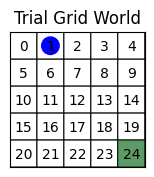

Rewards Function:
 [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
 10.  ]
Transition Matrix for State 1:
 [[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [18]:
n_rows, n_cols = 5, 5
step_penalization = -0.01
gw_open = GridWorld(rows=n_rows,cols=n_cols,
                  #obstacles=[(2,2),(2,3),(2,4),(3,2)], 
                  rewards={(4,4):10},  # Note that python indexing starts with 0
                  terminals=[(4,4)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

print('Rewards Function:\n', gw_open.R)

print(f'Transition Matrix for State {gw_open.state}:\n', gw_open.P[:,gw_open.state,:].T)

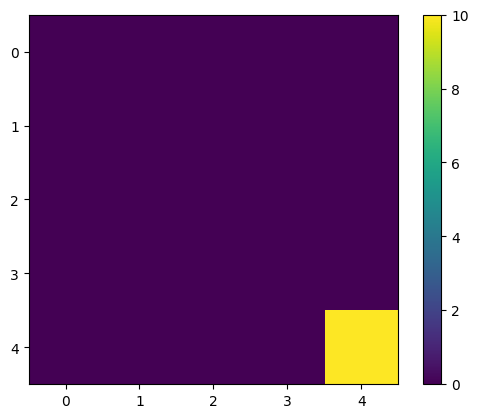

In [19]:
# Visualizing the reward function another way
def plot_reward_map(env):
    R_map = plt.imshow(env.R.reshape(n_rows,n_cols))
    plt.colorbar(R_map)
    plt.show()
    
plot_reward_map(gw_open)

In [20]:
## take a single step in the environment
original_state = gw_open.state
action_name = 'Down'
action_index = gw_open.action_list.index(action_name)
updated_state, reward, done, info = gw_open.step(action_index)
print(f"From state {original_state}, Agent chose action {action_name}, received reward {reward}, and transitioned to state {updated_state}")

From state 1, Agent chose action Down, received reward -0.01, and transitioned to state 6


In [21]:
class RandomAgent(object):
    def __init__(self, num_actions):
        self.num_actions = num_actions
    def select_action(self, state): ## THIS IS THE POLICY FOR BEHAVIOUR
        # state actually does nothing in this agent, but we will want our action selection
        # in later agents to be based on the state we're in so we are setting up the pattern to follow
        action = np.random.choice(self.num_actions)
        return action

<b><span style='color:blue'>Here we will write the code that takes steps in the environment. Make a call to the random agent to get an action, and then take a step in the environment. </span></b>

In [22]:
# Write a function to count the number of steps it takes for the agent to reach the end 
def navigate(gw, agent, num_runs=250):
    track_steps_to_finish = []
    track_rewards_achieved= []
    for run in range(num_runs):
        done = False
        move_counter   = 0
        reward_counter = 0
        # take moves in the environment until reach the terminal state:
        while not done:
            current_state = gw.state
            
            ## TO DO -- get an action from the random agent
            action = agent.select_action(current_state)
            
            ## TO DO -- take a step in the environment. 
            ##        from the cell above, what information does the step function return?
            updated_state, reward, done, info = gw.step(action)
            
            # keep running tally of rewards achieved
            reward_counter += reward 
            
            # keep track of how many steps it takes to get to the end
            move_counter += 1 
            
            #if run == 0:
            #    print(f'{current_state}/{action}-->{updated_state}')

        track_steps_to_finish.append(move_counter)
        track_rewards_achieved.append(reward_counter)
        gw.reset()
    return track_steps_to_finish, track_rewards_achieved

# Use a Random Agent to Move Through the Gridworld

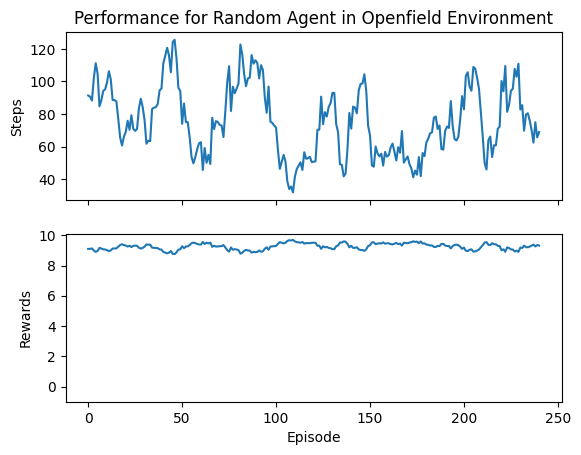

In [23]:
random_walker = RandomAgent(len(gw_open.action_list)) 

open_gw_steps,open_gw_rwds = navigate(gw_open, random_walker)


# plot performance
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(open_gw_steps, N=10))
ax[1].plot(running_mean(open_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')
ax[1].set_xlabel('Episode')
ax[0].set_title('Performance for Random Agent in Openfield Environment')
plt.show()

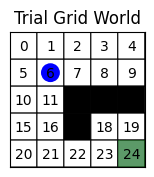

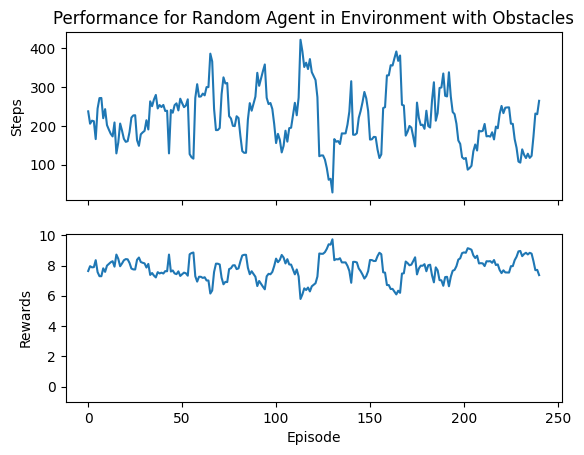

In [24]:
gw_obst = GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(2,2),(2,3),(2,4),(3,2)], 
                  rewards={(4,4):10},
                  terminals=[(4,4)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

obst_gw_steps,obst_gw_rwds = navigate(gw_obst, random_walker)

## Plot performance 
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(obst_gw_steps, N=10))
ax[1].plot(running_mean(obst_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_title('Performance for Random Agent in Environment with Obstacles')
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')
ax[1].set_xlabel('Episode')
plt.show()

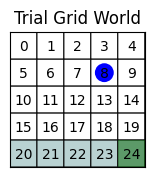

[20, 21, 22, 23, 24, 24]


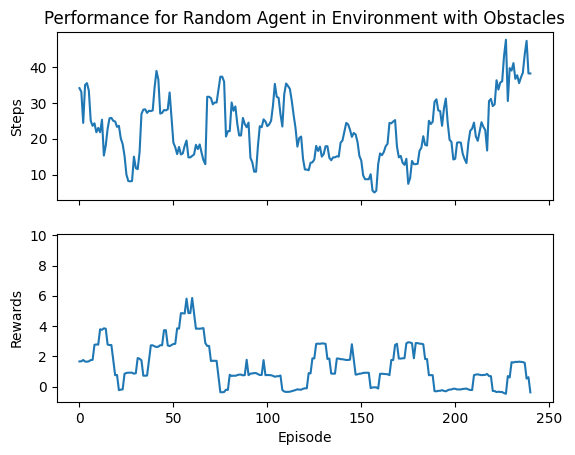

In [25]:
gw_cliff = GridWorld(rows=n_rows,cols=n_cols,
                  rewards={(4,4):10},
                  terminals=[(n_rows-1,c) for c in range(n_cols)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=True
                 )

print(gw_cliff.terminal)

cliff_gw_steps, cliff_gw_rwds = navigate(gw_cliff, random_walker)

## Plot performance 
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(cliff_gw_steps, N=10))
ax[1].plot(running_mean(cliff_gw_rwds,N=10))
ax[1].set_ylim(-1,10.1)
ax[0].set_title('Performance for Random Agent in Environment with Obstacles')
ax[0].set_ylabel('Steps')
ax[1].set_ylabel('Rewards')
ax[1].set_xlabel('Episode')
plt.show()

Text(0.5, 0, 'Episode')

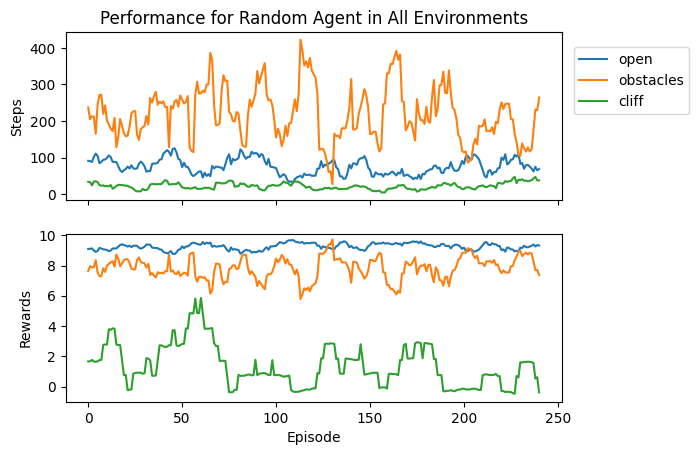

In [26]:
## Plot performance 
smoothing = 10

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(running_mean(open_gw_steps, N=smoothing),label='open')
ax[0].plot(running_mean(obst_gw_steps, N=smoothing),label='obstacles')
ax[0].plot(running_mean(cliff_gw_steps, N=smoothing),label='cliff')

ax[0].set_title('Performance for Random Agent in All Environments')
ax[0].set_ylabel('Steps')
ax[0].legend(bbox_to_anchor=(1.01,0.95))

ax[1].plot(running_mean(open_gw_rwds,N=smoothing),label='open')
ax[1].plot(running_mean(obst_gw_rwds,N=smoothing),label='obstacles')
ax[1].plot(running_mean(cliff_gw_rwds,N=smoothing),label='cliff')
ax[1].set_ylim(-1,10.1)
ax[1].set_ylabel('Rewards')
ax[1].set_xlabel('Episode')

#avg_steps = [np.mean(open_gw_steps),np.mean(obst_gw_steps),np.mean(cliff_gw_steps)]
#avg_rwds  = [np.mean(open_gw_rwds),np.mean(obst_gw_rwds),np.mean(cliff_gw_rwds)]


What do you observe from the performance in the obstacles and cliff gridworlds?

<b><span style="color: blue;"> Try changing the step penalization above and rerun these simulations -- see what happens to the reward collected with the random agent in each type of environment. </span></b>

# Some larger example environments

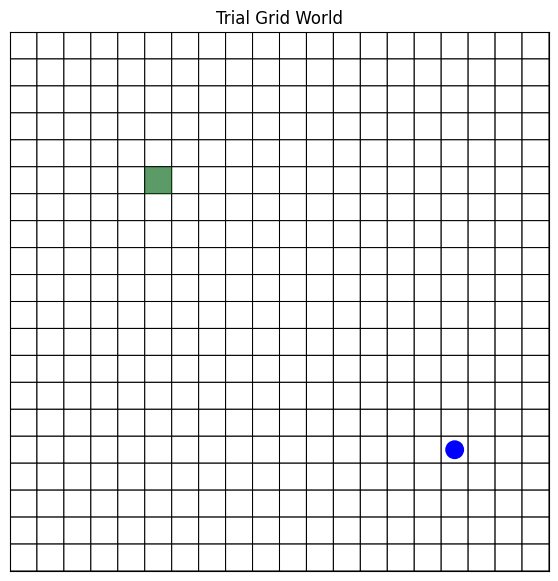

In [27]:
gw_open_large = GridWorld()

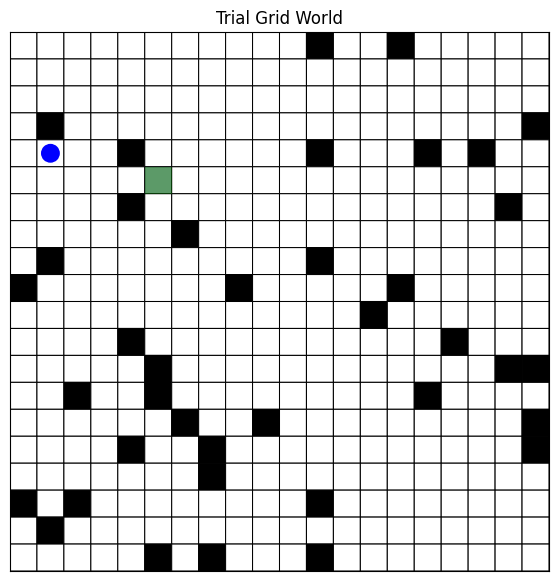

In [28]:
gw_random_obs = GridWorld_random_obstacle()

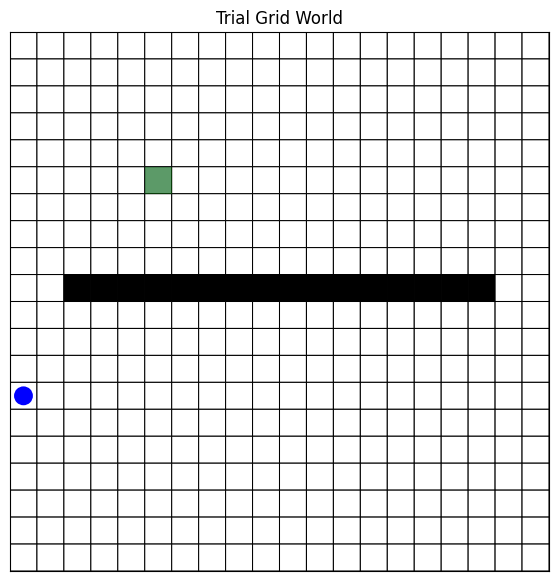

In [29]:
gw_divided = GridWorld_bar()

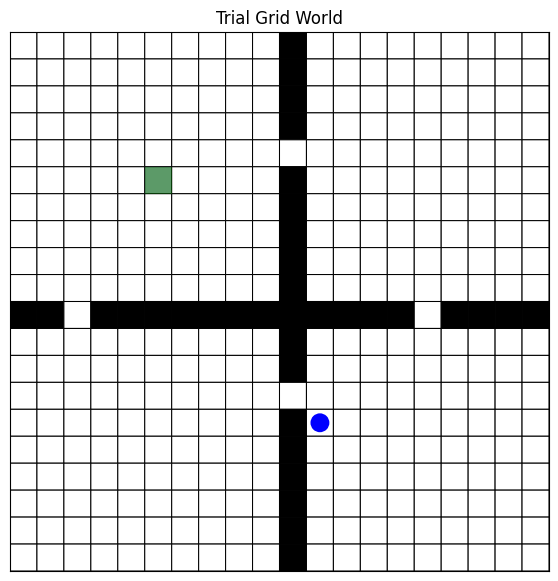

In [30]:
gw_4rooms = GridWorld_4rooms()

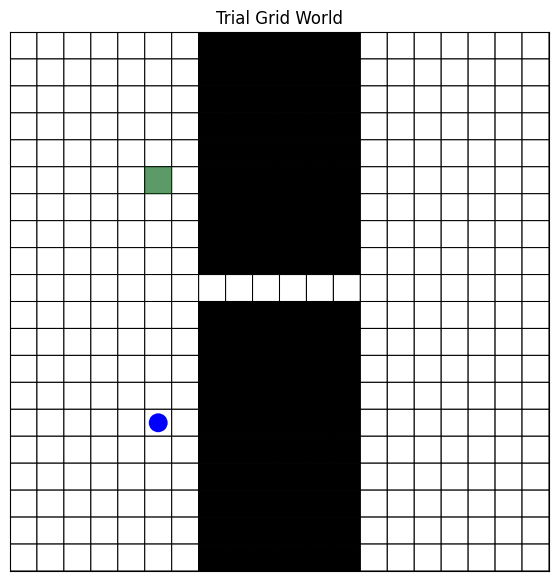

In [31]:
gw_tunnel = GridWorld_tunnel()

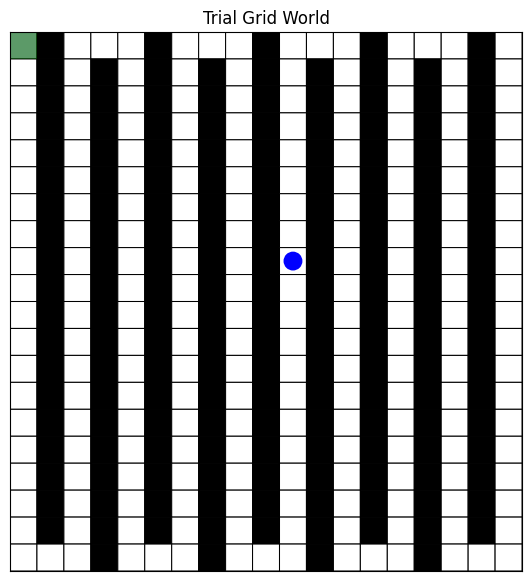

In [32]:
gw_hairpinmaze = GridWorld_hairpin()

<b><span style='color:DarkGreen'>Homework: Test the random walk agent on the `gridworld_open` and `gridworld_open_large` environments, and plot the rewards achieved in both.</span></b>

These larger spaces are unlikely to yield much reward, especially for agents using a random policy. 

Next, we will look at some ways agents learn how to behave by evaluating how much reward each action is likely to lead to in the long term.

# Section 3: Understanding Agents & *Actually Learning* from Trial and Error

### First we will choose an environment to test all of our learners in 

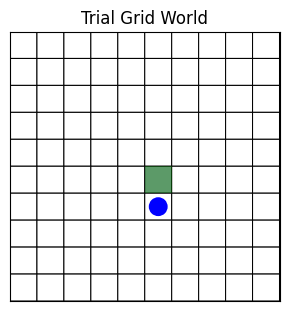

In [33]:
n_rows, n_cols = 10,10
step_penalization = -0.01
env = GridWorld(rows=n_rows,cols=n_cols,
                  #obstacles=[(3,2),(3,3),(3,4),(4,2),(5,2),(3,5),(3,6),(3,7)], 
                  rewards={(5,5):10},
                  terminals=[(5,5)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False)

### Let's set up the basic framework that all of our tabular agents will use

<b><span style='color:blue'> Write the $\epsilon$-greedy action selection function. </span></b>

In [34]:
class TabularAgent(object):
    def __init__(self, nstates, nactions, 
                 learning_rate=0.1, discount=0.9, epsilon=1.0):
        
        self.num_actions = nactions
        self.action_space = np.arange(self.num_actions)

        # this agent selects actions from a table of <state,action> values which we initalize randomly
        #self.q_table = np.random.uniform(low=-1, high=1, size=(nstates, nactions))
        self.q_table = np.zeros((env.nstates, env.nactions))

        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount
        
    def choose_action(self, state):
        # this agent uses epsilon-greedy action selection, meaning that it selects 
        # the greedy (highest value) action most of the time, but with epsilon probability
        # it will select a random action -- this helps encourage the agent to explore
        # unseen trajectories
        
        ## TO DO -- write action selection for an epsilon-greedy policy 
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.q_table[state])
        else: 
            action = np.random.choice(self.action_space)
        return action

Now that we've told the agent how to select actions based on the values, the next question is: how do we know the values of each state-action pair, i.e. $q(s,a)$?

## Monte Carlo Agents Update Q Values From Computed Return

<b><span style='color:blue'> Write Q value update using Monte Carlo learning. </span></b>

Recall: Monte Carlo sampling is where you sample trajectories and calculate their return $G$ to estimate state-action-values. 

In [38]:
# MC Learning of the state value function
class MC_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    def update_q_table(self, current_state, current_action, computed_return):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[current_state, current_action]
        
        ## TO DO -- write the Q value update step
        new_q = current_q + self.learning_rate*(computed_return - current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, env, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            env.reset()
            # initalize reward counter
            total_reward=0

            # get first state and action
            if random_start:
                state=np.random.choice(env.nstates)
            else:
                state=start
            
            states, actions, rewards = [], [], []
            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = env.step(action)

                total_reward+=reward

                if not done:
                    states.append(state)
                    actions.append(action)
                    rewards.append(reward)
                else:
                    break
                state=next_state
            
            # compute return
            returns = discount_rwds(rewards, gamma=0.9)
            # use the returns from the sampled trajectory to update the value of every s-a pair experienced
            for i in range(len(states)):
                self.update_q_table(states[i],actions[i],returns[i])
            
            reward_tracking.append(total_reward)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking

### How does the MC Agent Perform in this environment? 

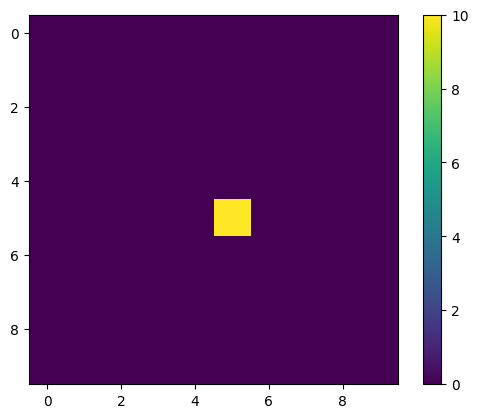

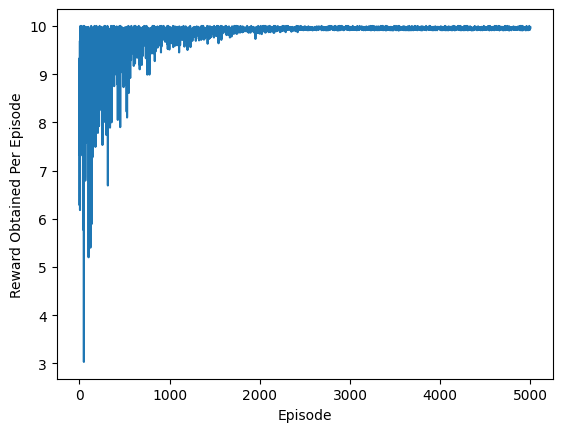

In [40]:
## let's look at the reward function on the environment:
plot_reward_map(env)

## run the MC agent through the environment to learn the reward landscape 
mc_learner = MC_Agent(env.nstates, env.nactions)
mc_rewards = mc_learner.navigate(env, num_episodes=5000)

## show the rewards achieved 
plt.plot(mc_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()

### Let's look at what the agent has learned by inspecting the Q values in its table

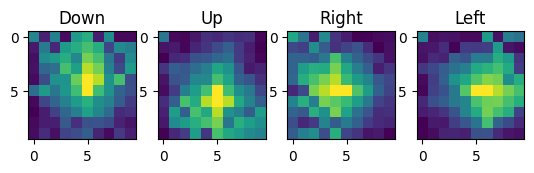

In [41]:
## show the value map learned by the agent
# Show values for each action
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(mc_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[i].set_title(env.action_list[i])
plt.show()

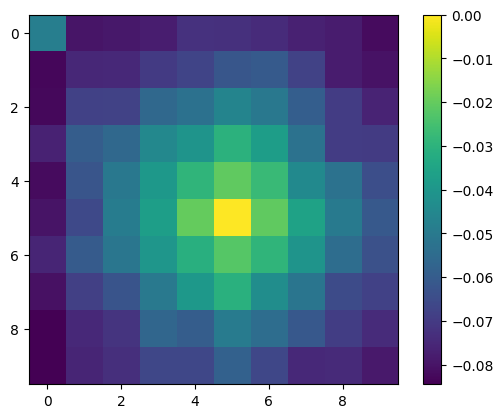

In [42]:
# show average across actions ~ V(s)
a = np.mean(mc_learner.q_table, axis=1).reshape(n_rows,n_cols)

f = plt.imshow(a)
plt.colorbar(f)
plt.show()

## TD Learning Methods: SARSA and Q-Learning

Now we will look at an alternative strategy for learning state-action-values: Temporal difference (TD) learning. TD learning uses one piece of experience information (one-step observed reward) plus its guess of future value to update its guess of the state value. 

Q learning and SARSA are two different methods of doing TD learning. They differ based on which policy they use for learning. SARSA is an **on** policy algorithm, meaning it uses the same policy for behaviour (selecting actions) and for optimization (learning updates). Q-learning is an **off** policy algorithm, meaning it uses a different policy for behaving ($\epsilon$-greedy policy) and for optimizing (pure greedy policy). 

<b><span style='color:blue'>Write the Q value update using SARSA-learning. Also, re-write the navigation function to maintain the relevant information needed to do SARSA</span></b>

In [43]:
## SARSA -- same same but different
class SARSA_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    #updates q values after each step 
    # similar to Q update but with one key difference -- we use the action we *actually* took
    # rather than guessing we took the max value action
    # with epsilon probability, we will have actually taken a random action, so SARSA wants to account for that 
    
    ## TO DO -- write the update to the Q table using SARSA. What arguments are needed for this function?
    def update_q_table(self,current_state,current_action,reward,next_state,next_action):
        current_q = self.q_table[current_state, current_action]
        future_q = self.q_table[next_state,next_action]
        
        ## TO DO -- write the Q Value update using SARSA
        new_q = current_q + self.learning_rate*(reward + self.discount*future_q - current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, env, num_episodes, random_start=False, start=0): # takes sarsa_agent as input 
        #-- will not work w Q_agent bc takes additional argument of next_state in update_q_table function
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 100

        for episode in range(num_episodes):
            env.reset()
            # initalize reward counter
            total_reward=0

            # get first state and action
            if random_start:
                state=np.random.choice(env.nstates)
            else:
                state=start
            action = self.choose_action(state)
            
            ## TO DO -- write the procedure for a single step for SARSA 
            ## Hint: Notice how next_action is used in self.update_q_table and env.step?
            ## That's because the target policy and the behavioural policy are the same in SARSA.
            
            for step in range(max_steps):
                # take a step in the environment
                next_state, reward, done, _ = env.step(action)

                total_reward+=reward

                if not done:
                    next_action = self.choose_action(next_state)
                    self.update_q_table(state,action,reward,next_state,next_action)
                else:
                    self.q_table[state,action]= 0 
                    break
                state=next_state
                action=next_action

            reward_tracking.append(total_reward)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking

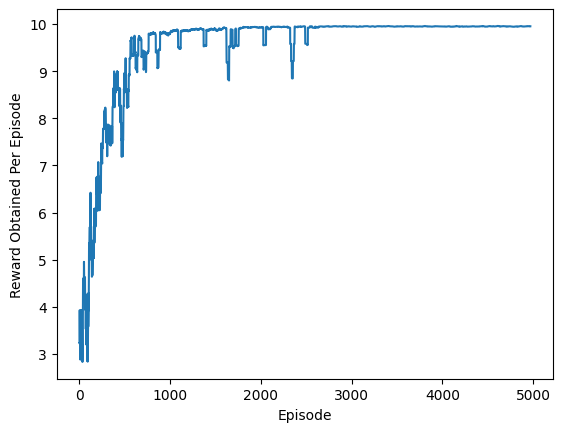

In [44]:
sarsa_learner = SARSA_Agent(env.nstates, env.nactions)
sarsa_rewards = sarsa_learner.navigate(env, num_episodes=5000)

plt.plot(running_mean(sarsa_rewards,N=30))
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()

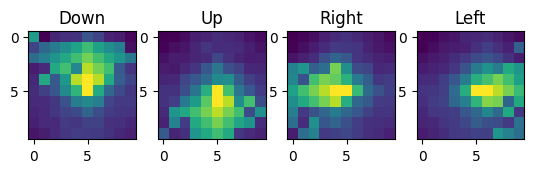

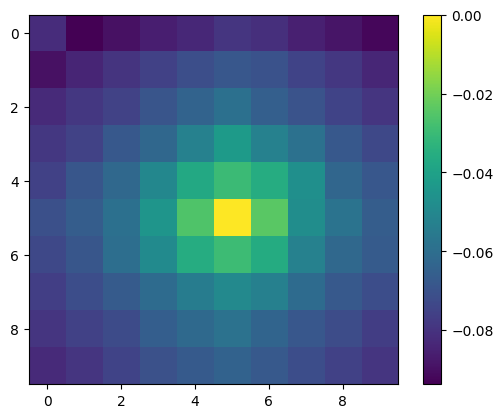

In [45]:
# show values under different learners
# Show values for each action
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(sarsa_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[i].set_title(env.action_list[i])
plt.show()

# show average across actions ~ V(s)
a = np.mean(sarsa_learner.q_table, axis=1).reshape(n_rows,n_cols)

f = plt.imshow(a)
plt.colorbar(f)
plt.show()

### Because Q and SARSA need to keep track of slightly different information, we will write two functions for how they navigate the environment 

<b><span style='color:blue'>Write the Q value update using Q-learning. </span></b>

In [46]:
# TD Agents
class Q_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    def update_q_table(self, current_state, current_action, reward, new_state):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[current_state, current_action]
        max_future_q = np.max(self.q_table[new_state,:])
        
        ## TO DO -- write the Q value update using Q-learning
        new_q = current_q + self.learning_rate*(reward + self.discount*max_future_q - current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, env, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            env.reset()
            # initalize reward counter
            total_reward=0

            # get first state and action
            if random_start:
                state=np.random.choice(env.nstates)
            else:
                state=start
            
            ## TO DO -- write the procedure for a single step for Q-Learning
            ## Hint: The behavioural policy and the target policy are different in Q-learning.
            
            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = env.step(action)

                total_reward+=reward

                if not done:
                    self.update_q_table(state, action, reward, next_state)
                else:
                    self.q_table[state, action] = 0
                    break
                state=next_state

            reward_tracking.append(total_reward)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking

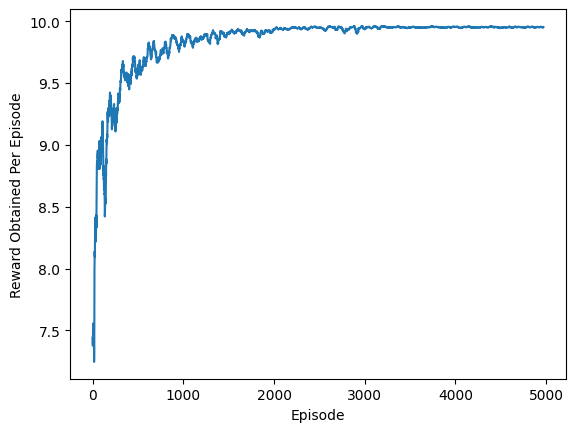

In [47]:
q_learner = Q_Agent(env.nstates, env.nactions)
q_rewards = q_learner.navigate(env, num_episodes=5000)

plt.plot(running_mean(q_rewards,N=30))
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()

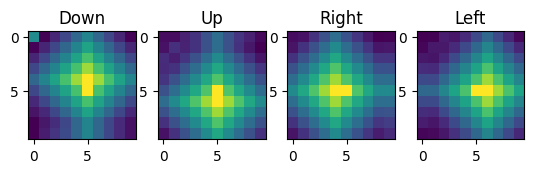

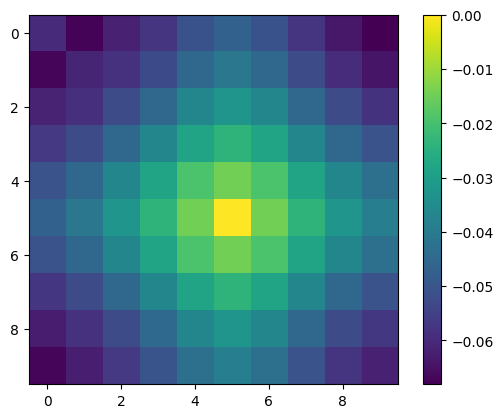

In [48]:
# Show values for each action
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(q_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[i].set_title(env.action_list[i])
plt.show()

# show average across actions ~ V(s)
a = np.mean(q_learner.q_table, axis=1).reshape(n_rows,n_cols)

f = plt.imshow(a)
plt.colorbar(f)
plt.show()

### Compare MC, SARSA, and Q-Learning

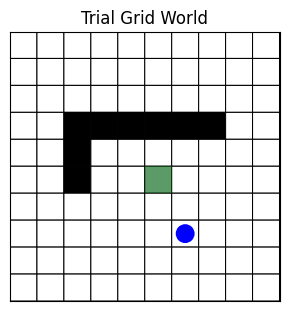

In [49]:
# make an environment we will use for these tabular agents 
n_rows, n_cols = 10,10
step_penalization = -0.01
env = GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(3,2),(3,3),(3,4),(4,2),(5,2),(3,5),(3,6),(3,7)], 
                  rewards={(5,5):10},
                  terminals=[(5,5)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False)

Reward Function in Environment:


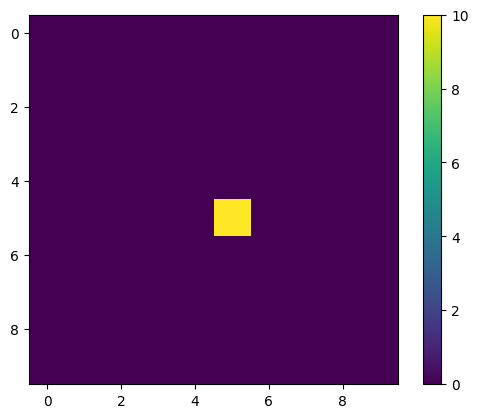

Running MC Agent...
Done
Running Q-Learning Agent...
Done
Running SARSA Agent...
Done


In [50]:
## let's look at the reward function on the environment:
print('Reward Function in Environment:')
plot_reward_map(env)

number_of_episodes = 5000

## run the MC agent through the environment
mc_learner = MC_Agent(env.nstates, env.nactions)
print('Running MC Agent...'),
mc_rewards = mc_learner.navigate(env, num_episodes=number_of_episodes)
print('Done')

## run the Q learning agent through the environment 
q_learner = Q_Agent(env.nstates, env.nactions)
print('Running Q-Learning Agent...')
q_rewards = q_learner.navigate(env, num_episodes=number_of_episodes)
print('Done')

## run the Q learning agent through the environment 
sarsa_learner = SARSA_Agent(env.nstates, env.nactions)
print('Running SARSA Agent...')
sarsa_rewards = sarsa_learner.navigate(env, num_episodes=number_of_episodes)
print('Done')

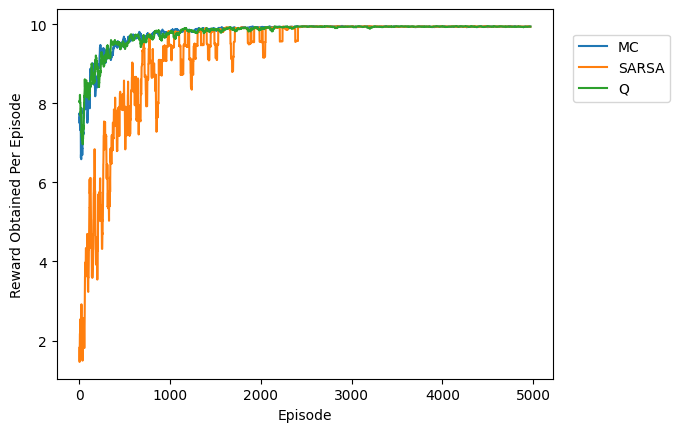

In [51]:
## Plot agent performance for all agents
smoothing = 30
plt.plot(running_mean(mc_rewards,N=smoothing), label='MC')
plt.plot(running_mean(sarsa_rewards,N=smoothing), label='SARSA')
plt.plot(running_mean(q_rewards,N=smoothing), label='Q')
plt.legend(bbox_to_anchor=(1.25,0.95))
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()

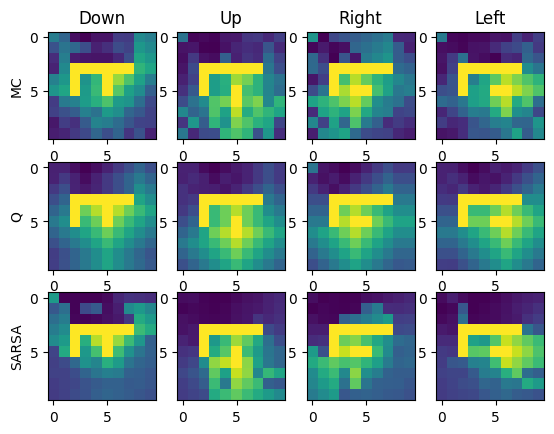

In [52]:
## Compare Values Learned by Agents 
fig, ax = plt.subplots(3,env.nactions)
for i in range(env.nactions):
    ax[0,i].imshow(mc_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[1,i].imshow(q_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[2,i].imshow(sarsa_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[0,i].set_title(env.action_list[i])

ax[0,0].set_ylabel('MC')
ax[1,0].set_ylabel('Q')
ax[2,0].set_ylabel('SARSA')
plt.show()

<b><span style='color:blue'> Try the above code in different environments, see how these agents are similar or different depending on the conditions they have to learn </span></b>

# Mini Projects 

### Level 0: I want to get a better sense of the fundamentals
- Create your own variant of a gridworld task and solve it using the one (or all) of the learners we built during the turorial (MC/Q/SARSA agents)
    - Specify your own reward and transition functions (eg. what if you made a gridworld where the agent moved like Pacman?).  
    - Explore action-dependent reward functions. What if the agent can only get the reward by taking a specific action? Introduce a new 'special' action in addition to Up/Down/Left/Right. Remember to account for this in both your transition function and reward functions.
   

### Level 1: I'm comfortable with fundamentals and want to try an extension of something we did already
- Explore making a new kind of environment. Solve the Knight's Tour task (suggestion: try both MC and Q learning, pick one to start and if you get it working, try the other).
<div><img src='https://images.chesscomfiles.com/uploads/v1/images_users/tiny_mce/PedroPinhata/phpT00lSF.png'></div>
  - The Knight's Tour problem is to move a knight around a chess board such that it visits every position on the 8x8 board once and only once. The knight moves in an L-shape. 
  - For this problem you will need to write a new transition function for an 8x8 open field gridworld.
  - You will also need to determine how you want to shape the rewards for the task, as well as starting and stopping conditions. How does your agent get feedback?   
- Explore how the agents we looked at in a single environment behave across different environments. Compare and contrast the performance of a Q-Learner against a SARSA learner in different environments. 
    - A SARSA agent updates the Q table in an ''on-policy'' fashion -- i.e. using the same policy as the one used to select actions. By contrast, Q learning is an ''off-policy'' algorithm, where the agent updates its Q values using a different policy than the one it used to select actions (the agent selects actions with an epsilon greedy policy, but updates Q values with a greedy policy). 
    - Hint: Use the cliffworld environment -- why do these agents perform about the same in other environments, and what is it about this environment that highlights their differences?

### Level 2: I want to explore some things we hinted at but didn't go into detail
- Project: Build a model-based agent (Dyna Q) to navigate a gridworld task of your design (use the Gridworld class from env_functions) 

<div><img src='https://publish-01.obsidian.md/access/fc5a2dd092cb06eefdd04ff307334d7a/_attachments/Tabular%20Dyna-Q.png'></div>
    - A Dyna agent relies on interative phases of model construction from sampling experience, and action/rewards collection from acting based on model-generated 
- Project: Build a neural network to do Q learning (**) ~ DQN 

### Level 3: All this is childs play give me something hard
- Project: Solve a gridworld task with an actor-critic network agent -- use PyTorch
<div><img src='https://intellabs.github.io/coach/_images/ac.png'></div>
    - Construct a neural network (input / single hidden / output layers are fine, no need for deep architecture). What information do you want to include in the input? What information do you need in the actor & critic output layers? 
    - What are appropriate loss functions?
    - Decide how to represent the state information to the network. What sort of semantic details are important to include?


--------------------

# References 

- Sutton and Barto, An Introduction to Reinforcement Learning 
- David Silver [Lecture Notes](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)
- Omer Sezer RL Overview [Tutorials](https://github.com/omerbsezer/Reinforcement_learning_tutorial_with_demo) 


## Some interesting papers
- Q-Learning: V. Mnih, K. Kavukcuoglu, D. Silver, A. Graves, I. Antonoglou, et al. “Playing Atari with Deep Reinforcement Learning”. (2013).
- V. Mnih, K. Kavukcuoglu, D. Silver, et al. "Human-level control through deep reinforcement learning" (Nature-2015).
- Schulma et al. "Proximal Policy Optimization Algorithms"(2017).
- Hasselt et al. "Deep Reinforcement Learning with Double Q-learning" (2015).
- Schaul et al. "Prioritized Experience Replay" (2015).
- AlphaGo- Supervised learning + policy gradients + value functions + Monte Carlo tree search D. Silver, A. Huang, C. J.Maddison, A. Guez, L. Sifre, et al. “Mastering the game of Go with deep neural networks and tree search”. Nature (2016).

Model-based RL: https://compneuro.neuromatch.io/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial4.html

Links to neuroscience: https://compneuro.neuromatch.io/tutorials/W3D4_ReinforcementLearning/further_reading.html#links-to-neuroscience

Intro to Deep RL and DQN: https://deeplearning.neuromatch.io/tutorials/W3D4_BasicReinforcementLearning/student/W3D4_Tutorial5.html

PPO, DDPG, SAC: https://spinningup.openai.com/en/latest/algorithms/ppo.html